In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#drive.mount('/content/drive')

In [10]:
print (tf.__version__)

2.7.0-dev20210806


In [36]:
pwd

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan'

In [11]:
# data_dir='/content/drive/MyDrive/train/Untitled folder'

data_dir='/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images'

In [12]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [5]:
print(data_dir)
for name in data_dir.glob('*/*.jpeg'):
    print(name)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images/cattle/cattle_1.jpeg
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images/cattle/cattle_10.jpeg
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images/cattle/cattle_100.jpeg
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images/cattle/cattle_101.jpeg
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images/cattle/cattle_102.jpeg
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images/cattle/cattle_103.jpeg
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images/cattle/cattle_104.jpeg
/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/ars

In [13]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

1368


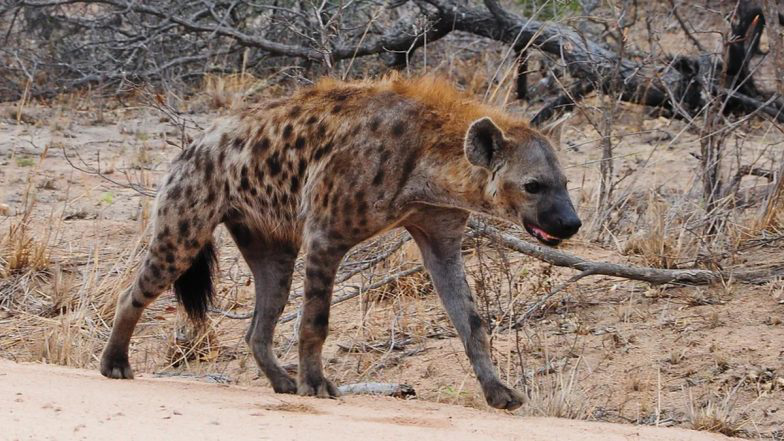

In [4]:
Hyena = list(data_dir.glob('hyena/*'))
PIL.Image.open(str(Hyena[1]))

In [14]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
tf.keras.preprocessing.image_dataset_from_directory

<function tensorflow.python.keras.preprocessing.image_dataset.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)>

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 7 classes.
Using 1125 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 7 classes.
Using 281 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['cattle', 'horse', 'hyena', 'leopard', 'lion', 'tiger', 'wolf']


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


class VGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # Initialize model and input shape
        model = Sequential()
        inputShape = (height, width, depth)
        channelDimension = -1

        # Block1: CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block2: CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block3: CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # First set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # Return the model
        return model


In [23]:
a=VGGNet

In [24]:
model=a.build(img_width ,img_height,3,10)


In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 180, 180, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
36/36 [==============================] - ETA: 0s - loss: 2.0227 - accuracy: 0.4293WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f06a4044ea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the 

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4943: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


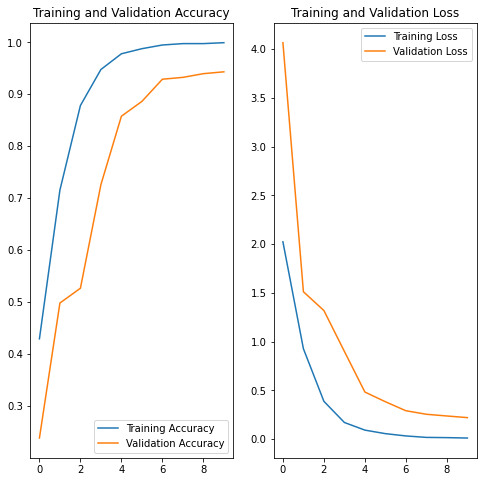

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
print("Accuracy : ",acc)

Accuracy :  [0.42933332920074463, 0.7155555486679077, 0.8782222270965576, 0.9475555419921875, 0.9777777791023254, 0.9875555634498596, 0.9946666955947876, 0.9973333477973938, 0.9973333477973938, 0.9991111159324646]


In [34]:
print("Validation_Accuracy : ",val_acc)

Validation_Accuracy :  [0.23843416571617126, 0.49822065234184265, 0.5266903638839722, 0.725978672504425, 0.8576512336730957, 0.8861209750175476, 0.9288256168365479, 0.9323843121528625, 0.9395017623901367, 0.9430605173110962]


In [35]:
print("Loss : ", loss)

Loss :  [2.022695302963257, 0.9258459210395813, 0.3861902058124542, 0.1692194938659668, 0.09092274308204651, 0.05477038025856018, 0.031334489583969116, 0.01634153537452221, 0.013994435779750347, 0.009812513366341591]


In [36]:
print("Validation Loss : ", val_loss)

Validation Loss :  [4.065305233001709, 1.5103809833526611, 1.3175709247589111, 0.8982876539230347, 0.48152878880500793, 0.3821673095226288, 0.2897687554359436, 0.25350573658943176, 0.23606981337070465, 0.21910613775253296]
